In [1]:
import pandas as pd

## Utils and Library for notebook
#from notebook_lib.nwpv.nwpv import nwpv_calculation
from notebook_utils.OpenKbcMSCalculator import nwpv_calculation as nwpv_calculator
from notebook_utils.OpenKbcMSToolkit import ExtractionToolkit as exttoolkit

# Root data path
DATA_PATH = '../data/'

# Sample loading
gene_tpm = pd.read_feather(DATA_PATH+"counts_normalized/counts_vst_CD8.feather").set_index('index') # Load normalized CD8
meta_data = pd.read_csv(DATA_PATH+'annotation_metadata/EPIC_HCvB_metadata_baseline_updated-share.csv')

# Getting Sample Info
# DiseaseStatus: ['MS' 'Unknown' 'CIS' 'Healthy']
# DiseaseDuration(Early?)
# DiseaseCourse: ['RR' 'PP' 'SP' 'RIS' 'CIS' 'Unknown' 'Healthy']
sample_list, sample_category = exttoolkit.get_sample_name_by_category(dataframe=meta_data, sampleColumn='HCVB_ID', dataColname='DiseaseCourse')
print("Sample Count")
count=0 
for category, values in zip(sample_category, sample_list):
    print(category+" : "+str(len(values)) + ", List number : " + str(count))
    count+=1

Sample Count
RR : 82, List number : 0
PP : 14, List number : 1
SP : 1, List number : 2
RIS : 2, List number : 3
CIS : 40, List number : 4
Unknown : 1, List number : 5
Healthy : 22, List number : 6


In [2]:
duration_df = meta_data.dropna(subset=['DiseaseDuration']) # data for patient's duration set
duration_df['DiseaseDuration'] = duration_df['DiseaseDuration'].astype(float) # make float

## Long DD
longDD_samples = duration_df.loc[ duration_df['DiseaseDuration'] >= duration_df['DiseaseDuration'].median(), 'HCVB_ID'] # Get sampleData which has longDD from metadata
longDD_sampleList = list(set(gene_tpm.columns.tolist()).intersection(longDD_samples.values.tolist())) # Get intersected sampleID between expr and longDD
longDD_meta = duration_df[duration_df['HCVB_ID'].isin(longDD_sampleList)] # Get meta with sampleNames
#longDD_gene_expr = gene_tpm[longDD_sampleList] # Get expr with sampleNames

## Short DD
shortDD_samples = duration_df.loc[ duration_df['DiseaseDuration'] < duration_df['DiseaseDuration'].median(), 'HCVB_ID']
shortDD_sampleList = list(set(gene_tpm.columns.tolist()).intersection(shortDD_samples.values.tolist()))
shortDD_meta = duration_df[duration_df['HCVB_ID'].isin(shortDD_samples.values.tolist())]
#shortDD_gene_expr = gene_tpm[shortDD_sampleList]

/var/folders/sx/0rms4skn47nfn6svhhprv5700000gq/T/ipykernel_11157/331594947.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duration_df['DiseaseDuration'] = duration_df['DiseaseDuration'].astype(float) # make float


In [3]:
# NWPV calculation (Example for NWPV)
#nwpv_result = nwpv_calculator(gene_tpm, shortDD_sampleList, longDD_sampleList)

In [4]:
ext_gene_expr = gene_tpm[longDD_sampleList+shortDD_sampleList] ## Extracted gene expression
X = ext_gene_expr.T.values # Training sample
y = [0]*len(longDD_sampleList)+[1]*len(shortDD_sampleList) # Training y

Optimal number of features : 26


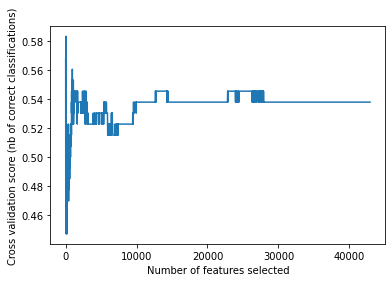

In [6]:
## RFE for feature selection(genes) between longDD and shortDD
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

## Reference: 
## https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html

estimator = SVC(kernel="linear") # linear
min_features_to_select = 1
rfecv = RFECV(estimator=estimator, step=1, cv=StratifiedKFold(2),\
    scoring='accuracy', min_features_to_select=min_features_to_select)
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
plt.show()

In [14]:
import numpy as np
print("RFECV features: ")
gene_tpm.index[np.where(rfecv.ranking_==1)]

RFECV features: 


Index(['ENSG00000022556.15_NLRP2', 'ENSG00000026297.15_RNASET2',
       'ENSG00000086289.11_EPDR1', 'ENSG00000110090.12_CPT1A',
       'ENSG00000129925.10_TMEM8A', 'ENSG00000134986.13_NREP',
       'ENSG00000143776.18_CDC42BPA', 'ENSG00000157514.16_TSC22D3',
       'ENSG00000166435.15_XRRA1', 'ENSG00000174130.12_TLR6',
       'ENSG00000175183.9_CSRP2', 'ENSG00000188199.10_NUTM2B',
       'ENSG00000204161.13_C10orf128', 'ENSG00000211710.3_TRBV4-1',
       'ENSG00000211829.9_TRDC', 'ENSG00000232629.8_HLA-DQB2',
       'ENSG00000236296.8_AC139713.1', 'ENSG00000241106.6_HLA-DOB',
       'ENSG00000245954.6_RP11-18H21.1', 'ENSG00000248672.5_LY75-CD302',
       'ENSG00000248874.5_C5orf17', 'ENSG00000253203.6_GUSBP3',
       'ENSG00000255513.1_AC005363.9', 'ENSG00000263069.5_CTD-2047H16.4',
       'ENSG00000264668.1_RP13-582O9.6', 'ENSG00000275131.2_CH17-472G23.4'],
      dtype='object', name='index')